A typical meshless surface reconstruction pipeline
- Moving Least Squares Smoothing around each point
- Estimate Normals (using PCA), around each point
- Re-orient Normals
- Radial Basis Function expansion around each point to construct surface

In [29]:
from scipy.spatial import cKDTree
from sklearn.neighbors import NearestNeighbors
from skimage import measure
import time
import matplotlib.pyplot as plt


In [2]:
# helper functions 
def gaussian_weight(r, h):
    return np.exp(-(r**2) / (h**2))

def pairwise_distances(A, B):
    # returns (len(A), len(B)) distances
    return np.linalg.norm(A[:, None, :] - B[None, :, :], axis=-1)

In [25]:
def mls_smooth(points , h = 0.5 , k = 30):
    # points - N x 3 matrix
    # h - gaussian bandwidth
    # returns smoothed points N x 3 matrix

    N = len(points)
    tree = cKDTree(points) # fast data-structure for querying for nearest neighs
    smoothed = np.zeros_like(points)

    # iterate over each point and do MLS smoothing
    for i,p0 in enumerate(points):
        dists,idx = tree.query(p0,k=k) # get the k NNs - returns their distances and indices
        neighbors = points[idx] # row[i] = [x_i, y_i, z_i]
        w = gaussian_weight(dists,h) # w[i] = gaussian_weight(dist[i],h)
        W = np.diag(w) # W[i][i] = w[i]

        # weighted centroid - mean of all neighborhood points. each neighborhood point is weighted by it's distance to p0
        p_bar = np.sum(
            w[:, None] * neighbors, axis=0 # this is just an element-wise product A[j,;] = w[j] * [neigh[j,x], neigh[j,y], neigh[j,z]]
        ) / np.sum(w)

        # weighted covariance
        X = neighbors - p_bar 
        C = X.T @ (W @ X) # this covariance matrix is constructed for each p0!!
        eigvals,eigvecs = np.linalg.eigh(C)

        n = eigvecs[:,0] # get all rows and zeroth column
        u_axis = eigvecs[:,1]
        v_axis = eigvecs[:,2]

        # local coordinate - project {neigh} onto u,v,n axis
        U = X @ u_axis
        V = X @ v_axis
        Z = X @ n

        # quadratic basis [1, U, V, U^2, U*V, V^2]
        # expand Z[i] in terms of a_0 + a_1.u + a_2.v + a_3.u^2 + a_4.uv + a_5.v^2
        # estimate {a_0,a_1,a_2,a_3,a_4,a_5} by least-square minimization 
        A = np.vstack([np.ones_like(U), U, V, U**2, U*V, V**2]).T
        # A has 3 rows and 5 cols. 

        # solve the weighted least-squares (A^T.W.A)a = A^T.W.Z
        ATA = A.T @ (W@A)
        ATZ = A.T @ (W@Z)
        ATA += 1e-8 * np.eye(6) # small regularization for numerical stability
        a = np.linalg.solve(ATA,ATZ)

        # predicted heigh at (0,0) is a0
        z_fit = a[0]
        p_proj = p_bar +  z_fit * n
        smoothed[i] = p_proj

    return smoothed

In [16]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Example data points
data = np.array([[1, 2], [2,3], [3, 4], [5, 6], [7, 8]])

# Query points
# query_points = np.array([[2, 3], [3,4]])
query_points = data

# Fit the NearestNeighbors model
nbrs = NearestNeighbors(n_neighbors=4, algorithm='auto').fit(data)

# Get the distances and indices of the nearest neighbors
dists, idx = nbrs.kneighbors(query_points)
dists,idx

(array([[0.        , 1.41421356, 2.82842712, 5.65685425],
        [0.        , 1.41421356, 1.41421356, 4.24264069],
        [0.        , 1.41421356, 2.82842712, 2.82842712],
        [0.        , 2.82842712, 2.82842712, 4.24264069],
        [0.        , 2.82842712, 5.65685425, 7.07106781]]),
 array([[0, 1, 2, 3],
        [1, 0, 2, 3],
        [2, 1, 0, 3],
        [3, 2, 4, 1],
        [4, 3, 2, 1]]))

A few pointers about the `kneighbors` method:
- it returns `dists` and `idx`
- `dists` and `idx` are 2D matrix
- it has `n` rows and `k` columns
- `n` - number of points we passed into the `kneighbors` method. 
- `k` - number of neighbors we're finding - the first column is the nearest neighbor. the last column is the farthest neighbor
- In our example above, we're evaluating KNN for all points i.e `n = N`
    - Hence, the first column of `dists` is always 0 because self-distance = 0
    - and the first column of `idx` points to it's own index in the `query_points` array

In [27]:
def estimate_normals(points, k=20, weighted=True,h=None):
    # weighted: if True use gaussian_weights based on distance to central-point
    # h: gaussian-width. If None use median dist 

    N = len(points)
    nbrs = NearestNeighbors(n_neighbors = k+1, algorithm = 'kd_tree').fit(points)
    dists,idx = nbrs.kneighbors(points)

    normals = np.zeros((N,3))

    for i in range(N):
        neighbors = points[idx[i, 1:]] # exclude itself
        di = dists[i, 1:] # exclude itself
        if weighted:
            if h is None:
                hh = np.median(di)
            else:
                hh = h
            w = gaussian_weight(di,hh)
            W = np.diag(w)
            p_bar = np.sum(w[:,None] * neighbors, axis = 0) / np.sum(w)
            X = neighbors - p_bar
            C = X.T @ (W @ X) 
        else:
            p_bar = neighbors.mean(axis=0)
            X = neighbors - p_bar
            C = X.T @ X

        eigvals,eigvecs = np.linalg.eigh(C)
        normal = eigvecs[:, 0]
        normals[i] = normal / np.linalg.norm(normal)

    return normals
                

In [17]:
# re-orient normals
# do BFS over neighbor-graph
# re-orient normal if it's dot-product with propagated-normal is negative
def orient_normals(points, normals, k = 10):
    N = len(points)
    nbrs = NearestNeighbors(n_neighbors = k+1, algorithm='kd_tree').fit(points)
    dists,idx = nbrs.kneighbors(points)
    
    visited = np.zeros(N, dtype=bool) # an array of size N where each i says whether we've visited and re-oriented the normal there
    queue = [0] # start at 0th point
    visited[0] = True
    while queue:
        i = queue.pop(0)
        neigh_idx = idx[i,1:] # exclude self 
        for j in neigh_idx:
            if not visited[j]:
                # flip if pointing opposite
                dot_prod = np.dot(normals[i],normals[j])
                if dot_prod < 0:
                    normals[j] *= -1
                visited[j] = True
                queue.append(j) # j becomes the next normal we investigate
    return normals
    

In [19]:
def gaussian_rbf_matrix(A, B, epsilon):
    D = pairwise_distances(A, B)
    return np.exp(- (epsilon * D) ** 2)

In [33]:
def rbf_reconstruction(points , normals , delta = 0.05 , epsilon = 2.0 , poly_degree  = 1):
    # points : N samples of points
    # normals : N normals, with consistent orientation
    # delta : perturbation delta for generating inside/outside points
    # epsilon : gaussian-width
    # poly_degree : 0 = constant (a0). 1 = linear (a0 + a1.x + a2.y + a3.z) 
    # returns weights w, a 

    N = len(points)
    # construct sample positoin Q and target-vlue f
    pts_surface = points
    pts_in  = points - delta*normals
    pts_out = points + delta*normals

    Q = np.vstack([pts_surface, pts_in, pts_out]) # 3N rows, 3 cols
    f_vals = np.concatenate([np.zeros(N), -delta * np.ones(N), +delta * np.ones(N)])  # 3N rows, 1 col

    # the f_vals[i] = 0 if Q[i] is a point on the surface. f_vals[i] = delta if Q[i] is outside the surface. and -delta if Q[i] is inside surface 

    # kernel matrix Phi - distance between the 3N generated points and the N original points 
    Phi = gaussian_rbf_matrix(Q, points, epsilon) # 3N rows, N cols
    
    if poly_degree == 0:
        P = np.ones(( len(Q), 1 )) # 3N rows, 1 col
    else:
        P = np.hstack([np.ones((len(Q), 1)), Q]) # 3N rows, 4 cols. each row is [1, q[x], q[y], q[z]]

    # Assemble block system:
    # [ Phi  P ] [w] = [f]
    # [ P^T 0 ] [a]   [0]
    
    top = np.hstack([Phi, P])
    # Mpoly = P.shape[1]
    # bottom = np.hstack([P.T, np.zeros((Mpoly, Mpoly))])
    # A = np.vstack([top, bottom])
    # b = np.concatenate([f_vals, np.zeros(Mpoly)])
    A = top.copy()
    b = f_vals.copy()

    # Solve with least squares 
    A_reg = A.copy()
    A_reg[:N, :N] += 1e-8 * np.eye(N) # small regularization on diagonal of Phi-block for stability

    sol, *_ = np.linalg.lstsq(A_reg, b, rcond=None) # *_ means discard all other returned values except the first
    w = sol[:N]
    a = sol[N:]
    return w, a, points

    


In [34]:
def evaluate_on_grid(w, a, centers, grid_bounds, grid_res=60, epsilon=2.0):
    """
    Evaluate f(x) on a regular grid.
    grid_bounds: ((xmin,xmax),(ymin,ymax),(zmin,zmax))
    """
    (xmin,xmax),(ymin,ymax),(zmin,zmax) = grid_bounds
    xs = np.linspace(xmin, xmax, grid_res)
    ys = np.linspace(ymin, ymax, grid_res)
    zs = np.linspace(zmin, zmax, grid_res)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="xy")
    grid_pts = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)
    Phi_eval = gaussian_rbf_matrix(grid_pts, centers, epsilon)  # (grid_pts, Mcenters)
    if a.size == 1:
        P_eval = np.ones((len(grid_pts), 1))
    else:
        P_eval = np.hstack([np.ones((len(grid_pts),1)), grid_pts])
    f_eval = Phi_eval @ w + P_eval @ a
    F = f_eval.reshape(X.shape)
    return (X, Y, Z, F, xs, ys, zs)

# -------------------------
# 7) Demo pipeline on noisy sphere
# -------------------------
def demo_pipeline():
    np.random.seed(0)
    # sample points on sphere with radial noise
    N = 600
    phi = 2 * np.pi * np.random.rand(N)
    costheta = 2 * np.random.rand(N) - 1
    theta = np.arccos(costheta)
    r = 1.0 + 0.03 * np.random.randn(N)  # radial noise
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    pts = np.vstack([x, y, z]).T

    # 1) MLS smoothing
    t0 = time.time()
    pts_smooth = mls_smooth(pts, h=0.4, k=40)
    print("MLS smoothing done (time {:.2f}s)".format(time.time() - t0))

    # 2) Normals (weighted PCA)
    t0 = time.time()
    normals = estimate_normals(pts_smooth, k=30, weighted=True, h=0.5)
    normals = orient_normals(pts_smooth, normals, k=10)
    print("Normals estimated and oriented (time {:.2f}s)".format(time.time() - t0))

    # visualize a subset of normals
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=4, color='gray')
    ax.set_title("Original noisy points")
    ax2 = fig.add_subplot(122, projection='3d')
    idxq = np.arange(0, len(pts_smooth), max(1, len(pts_smooth)//200))
    ax2.quiver(pts_smooth[idxq,0], pts_smooth[idxq,1], pts_smooth[idxq,2],
               normals[idxq,0], normals[idxq,1], normals[idxq,2],
               length=0.12, color='orange')
    ax2.scatter(pts_smooth[:,0], pts_smooth[:,1], pts_smooth[:,2], s=4, color='blue')
    ax2.set_title("Smoothed points + estimated normals")
    plt.show()

    # 3) RBF implicit reconstruction
    t0 = time.time()
    w, a, centers = rbf_reconstruction(pts_smooth, normals, delta=0.05, epsilon=2.0, poly_degree=1)
    print("RBF system solved (time {:.2f}s)".format(time.time() - t0))

    # 4) Evaluate on grid and marching cubes
    bbox = pts_smooth.max(axis=0)
    bbmin = pts_smooth.min(axis=0)
    pad = 0.3
    grid_bounds = ((bbmin[0]-pad, bbox[0]+pad),
                   (bbmin[1]-pad, bbox[1]+pad),
                   (bbmin[2]-pad, bbox[2]+pad))
    X, Y, Z, F, xs, ys, zs = evaluate_on_grid(w, a, centers, grid_bounds, grid_res=80, epsilon=2.0)

    # marching cubes (note: skimage expects volume with axis order (x,y,z) from X,Y,Z above)
    verts, faces, normals_mc, values = measure.marching_cubes(F, level=0.0, spacing=(xs[1]-xs[0], ys[1]-ys[0], zs[1]-zs[0]))
    # convert verts to world coords
    verts_world = verts + np.array([xs[0], ys[0], zs[0]])

    # plot result
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(verts_world[:,0], verts_world[:,1], faces, verts_world[:,2], color='lightblue', alpha=0.8, linewidth=0)
    ax.scatter(pts_smooth[:,0], pts_smooth[:,1], pts_smooth[:,2], s=3, color='red')
    ax.set_title("RBF implicit reconstruction (marching cubes)")
    plt.show()

    return pts, pts_smooth, normals, (w,a,centers)

# if __name__ == "__main__":
#     demo_pipeline()


MLS smoothing done (time 0.22s)
Normals estimated and oriented (time 0.10s)


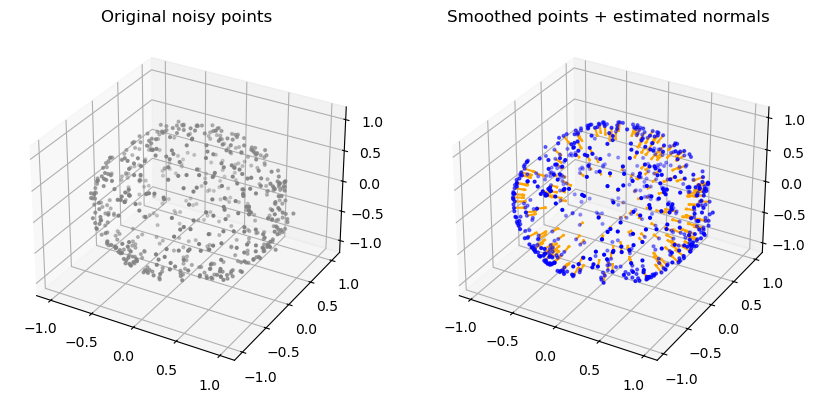

RBF system solved (time 0.19s)


In [ ]:
demo_pipeline()